In [207]:
%%time
from joblib import Parallel, delayed
import multiprocessing

inputs = range(100000) 
def processInput(i):
    return i * i

num_cores = multiprocessing.cpu_count()

results = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)
print(num_cores)

16
CPU times: user 1.5 s, sys: 149 ms, total: 1.65 s
Wall time: 1.69 s


In [13]:
%%time

inputs = range(100000) 
def processInput(i):
    return i * i
[processInput(i) for i in inputs];

CPU times: user 11.6 ms, sys: 727 µs, total: 12.3 ms
Wall time: 11.8 ms


[0,
 1,
 4,
 9,
 16,
 25,
 36,
 49,
 64,
 81,
 100,
 121,
 144,
 169,
 196,
 225,
 256,
 289,
 324,
 361,
 400,
 441,
 484,
 529,
 576,
 625,
 676,
 729,
 784,
 841,
 900,
 961,
 1024,
 1089,
 1156,
 1225,
 1296,
 1369,
 1444,
 1521,
 1600,
 1681,
 1764,
 1849,
 1936,
 2025,
 2116,
 2209,
 2304,
 2401,
 2500,
 2601,
 2704,
 2809,
 2916,
 3025,
 3136,
 3249,
 3364,
 3481,
 3600,
 3721,
 3844,
 3969,
 4096,
 4225,
 4356,
 4489,
 4624,
 4761,
 4900,
 5041,
 5184,
 5329,
 5476,
 5625,
 5776,
 5929,
 6084,
 6241,
 6400,
 6561,
 6724,
 6889,
 7056,
 7225,
 7396,
 7569,
 7744,
 7921,
 8100,
 8281,
 8464,
 8649,
 8836,
 9025,
 9216,
 9409,
 9604,
 9801,
 10000,
 10201,
 10404,
 10609,
 10816,
 11025,
 11236,
 11449,
 11664,
 11881,
 12100,
 12321,
 12544,
 12769,
 12996,
 13225,
 13456,
 13689,
 13924,
 14161,
 14400,
 14641,
 14884,
 15129,
 15376,
 15625,
 15876,
 16129,
 16384,
 16641,
 16900,
 17161,
 17424,
 17689,
 17956,
 18225,
 18496,
 18769,
 19044,
 19321,
 19600,
 19881,
 20164,
 2

In [16]:
%%time
from analysis_utils import *
import numpy as np
%load_ext autoreload
import pandas as pd
scalingFactor = 200
rxndiff=dict()

print('Starting scaling = ', scalingFactor)
NR_scaledrates = {'k1r':718*200/scalingFactor,'k2f':1475*200/scalingFactor,'k2r_nr':1120*200/scalingFactor,'k3_nr':6*200/scalingFactor,'k4':209*200/scalingFactor}


#Growth rate = 3.0
path = "/Users/Akshay/Documents/TranslationDynamics/data/"

gr_sim = dict()

data = "191003_2210/"
for i in range(1,7):
    sim_i = computeTransportRxnTimes(path+data, 1e15, 1e15, 100*(i-1),100*(i-1)+100,cogtRNANum=i, ribosomeNum = 7,scaling=scalingFactor, NR_scaling = NR_scaledrates)
    gr_sim[i] = (CellLatencies(sim_i))

data = "191105_0908/"
for i in range(7,14):
    sim_i = computeTransportRxnTimes(path+data, 1e15, 1e15, 100*(i-1-6),100*(i-1-6)+100,cogtRNANum=i, ribosomeNum = 7,scaling=scalingFactor, NR_scaling = NR_scaledrates)
    gr_sim[i] = (CellLatencies(sim_i))


gr_dict = {'gr_1':gr_sim}

def computedElongationLatency_gr3_v2(gr25_ptRNA,gr25_pCodon,gr_dict):
    import numpy as np

    transportRxnResults = transportRxnCalc(gr_dict,gr25_ptRNA,gr25_pCodon)

    search_list = transportRxnResults[0]
    rxndiff['30'] = transportRxnResults[1:]
    return([rxndiff[d][2][0]+(1000/1475+1000/1529+1000/209+1000/200+1000/32) for d in rxndiff],[rxndiff[d][5][0] for d in rxndiff])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Starting scaling =  200
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
CPU times: user 53.2 s, sys: 334 ms, total: 53.5 s
Wall time: 53.9 s


In [32]:
###### Genetic algorithm for just tRNA shuffling ########

def run_ga(inputs):
    gr25_Codon = inputs[0]
    elong_t_tRNA_list = inputs[1]
    p_tRNA_list = inputs[2]
    gr_dict = inputs[3]
    mintRNA = inputs[4]
    maxtRNA = inputs[5]
    #### Compute fitness
    fitness = (1/np.array(elong_t_tRNA_list))/sum((1/np.array(elong_t_tRNA_list)))

    #### Number of candidates n removing as well as n mating to create n offspring
    n = 10

    #### Identify the least fit candidates from the population
    cull_indices = np.argpartition(fitness, n)[:n]

    #### Choose parents based on weighting fitness
    import random
    #parent_indices = np.array(random.choices(np.arange(len(p_tRNA_list)), fitness, k=10))
    parent_indices = np.argpartition(fitness, n)[-n:]
    p_tRNA_list=np.array(p_tRNA_list)
    parents = p_tRNA_list[parent_indices]

    #### Mate k random pairs of 2 without replacement and renormalize
    k=5
    couples = np.random.choice(np.arange(len(parents)), size = (k,2),replace=False)
    recombination_rate = 0.1
    mutation_rate  = 0.05

    recombined_children = list()
    recombined_children_elongt = list()
    for couple_index in couples:
        couple = parents[couple_index]
        recombination_num = int(len(couple[0])*recombination_rate)
        recombination_locs = np.random.choice(len(couple[0]),recombination_num)
        recombination_values_0 = couple[0][recombination_locs] 
        couple[0][recombination_locs] = couple[1][recombination_locs]
        couple[1][recombination_locs] = recombination_values_0
        
        #### Mutate children
        mutation_num = int(len(couple[0])*mutation_rate)
        recombination_locs = np.random.choice(len(couple[0]),mutation_num)
        couple[0][recombination_locs] = np.random.uniform(mintRNA,maxtRNA,mutation_num)
        couple[1][recombination_locs] = np.random.uniform(mintRNA,maxtRNA,mutation_num)
        
        ### Re-normalize each recombined children
        child_0 = couple[0]/np.sum(couple[0])
        child_1 = couple[1]/np.sum(couple[1])

        #### Compute elong_t of the recombined children
        elong_t_0, std_0 = computedElongationLatency_gr3_v2(child_0,gr25_pCodon,gr_dict);
        elong_t_1, std_1 = computedElongationLatency_gr3_v2(child_1,gr25_pCodon,gr_dict);
                

        ### Add children to list as well as their elong_t
        recombined_children.append(list(child_0))
        recombined_children.append(list(child_1))
        recombined_children_elongt.append(elong_t_0[0])
        recombined_children_elongt.append(elong_t_1[0])

    #### Have recombined children and their elong_t replaced culled candidates
    p_tRNA_list[cull_indices] = recombined_children
    elong_t_tRNA_list[cull_indices] = recombined_children_elongt
    return fitness, p_tRNA_list, elong_t_tRNA_list

    

In [17]:
%%time
### Codon array fixed
gr25_Codon = np.array([2.36, 1.26, 45.55, 34.17, 16.97, 57.86, 19.27, 33.74, 14.98, 22.31, 43.18, 7.67, 24.11, 24.87, 39.49, 11.81, 0.03, 0.63, 2.19, 9.31, 17.22, 55.01, 5.61, 29.21, 21.67, 0.52, 15.79, 43.86, 4.17, 2.61, 20.64, 26.7, 7.03, 0.19, 2.76, 3.81, 6.72, 16.52, 4.27, 2.73, 7.92, 23.25, 2.51, 1.98, 16.33, 11.68, 0.62, 0.67, 43.82, 20.59, 27.28, 7.01, 6.78, 14.21, 60.75, 0.82, 3.86, 4.09, 28.82, 5.18, 4.38, 1.09])
gr25_pCodon = gr25_Codon/np.sum(gr25_Codon)
gr25_ptRNA = [0.0602409638554217, 0.010542168674698798, 0.07379518072289158, 0.00602409638554217, 0.010542168674698798, 0.00602409638554217, 0.021084337349397596, 0.043674698795180725, 0.021084337349397596, 0.01204819277108434, 0.01807228915662651, 0.08433734939759038, 0.03162650602409639, 0.07228915662650603, 0.01204819277108434, 0.07078313253012049, 0.06325301204819278, 0.01656626506024097, 0.009036144578313254, 0.027108433734939763, 0.010542168674698798, 0.03012048192771085, 0.013554216867469882, 0.015060240963855425, 0.0075301204819277125, 0.010542168674698798, 0.0075301204819277125, 0.003012048192771085, 0.021084337349397596, 0.004518072289156627, 0.01656626506024097, 0.01204819277108434, 0.0015060240963855425, 0.009036144578313254, 0.01656626506024097, 0.019578313253012052, 0.015060240963855425, 0.027108434, 0.05873493975903616, 0.019578313]
gr25_ptRNA = gr25_ptRNA/np.sum(gr25_ptRNA)
elong_t_tRNA_list = np.load('RandomtRNA_FixedCodon_100sample_elong_t_list.npy')
p_tRNA_list = np.load('RandomtRNA_FixedCodon_100sample_p_Codon_tRNA_list.npy')


fitness_arr = list()
minelong_arr = list()
for i in range(5):
    fitness, p_tRNA_list, elong_t_tRNA_list = run_ga(gr25_Codon,elong_t_tRNA_list,p_tRNA_list,gr_dict,min(gr25_ptRNA),max(gr25_ptRNA))
    print(max(fitness))
    print(min(elong_t_tRNA_list))
    fitness_arr.append(max(fitness))
    minelong_arr.append(min(elong_t_tRNA_list))
#np.save('RandomtRNA_FixedCodon_1500sample_elong_t_list2',elong_t_tRNA_list)
#np.save('RandomtRNA_FixedCodon_1500sample_p_tRNA_list2',p_tRNA_list)
#np.save('minelong_arr2',minelong_arr)

0.010488399408659985
200.29460396853858
0.010462810190748998
199.63800155525678
0.010461305463861686
199.63800155525678
0.01043004218575482
199.63800155525678
0.01040257025311234
199.63800155525678
CPU times: user 1min, sys: 93.3 ms, total: 1min
Wall time: 1min


In [41]:
%%time
### Codon array fixed
gr25_Codon = np.array([2.36, 1.26, 45.55, 34.17, 16.97, 57.86, 19.27, 33.74, 14.98, 22.31, 43.18, 7.67, 24.11, 24.87, 39.49, 11.81, 0.03, 0.63, 2.19, 9.31, 17.22, 55.01, 5.61, 29.21, 21.67, 0.52, 15.79, 43.86, 4.17, 2.61, 20.64, 26.7, 7.03, 0.19, 2.76, 3.81, 6.72, 16.52, 4.27, 2.73, 7.92, 23.25, 2.51, 1.98, 16.33, 11.68, 0.62, 0.67, 43.82, 20.59, 27.28, 7.01, 6.78, 14.21, 60.75, 0.82, 3.86, 4.09, 28.82, 5.18, 4.38, 1.09])
gr25_pCodon = gr25_Codon/np.sum(gr25_Codon)
gr25_ptRNA = [0.0602409638554217, 0.010542168674698798, 0.07379518072289158, 0.00602409638554217, 0.010542168674698798, 0.00602409638554217, 0.021084337349397596, 0.043674698795180725, 0.021084337349397596, 0.01204819277108434, 0.01807228915662651, 0.08433734939759038, 0.03162650602409639, 0.07228915662650603, 0.01204819277108434, 0.07078313253012049, 0.06325301204819278, 0.01656626506024097, 0.009036144578313254, 0.027108433734939763, 0.010542168674698798, 0.03012048192771085, 0.013554216867469882, 0.015060240963855425, 0.0075301204819277125, 0.010542168674698798, 0.0075301204819277125, 0.003012048192771085, 0.021084337349397596, 0.004518072289156627, 0.01656626506024097, 0.01204819277108434, 0.0015060240963855425, 0.009036144578313254, 0.01656626506024097, 0.019578313253012052, 0.015060240963855425, 0.027108434, 0.05873493975903616, 0.019578313]
gr25_ptRNA = gr25_ptRNA/np.sum(gr25_ptRNA)
elong_t_tRNA_list = np.load('RandomtRNA_FixedCodon_100sample_elong_t_list.npy')
p_tRNA_list = np.load('RandomtRNA_FixedCodon_100sample_p_Codon_tRNA_list.npy')
num_cores = multiprocessing.cpu_count()


fitness_arr = list()
minelong_arr = list()
inputs=[[gr25_Codon,elong_t_tRNA_list,p_tRNA_list,gr_dict,min(gr25_ptRNA),max(gr25_ptRNA)] for i in np.arange(10)]
a = Parallel(n_jobs=num_cores)(delayed(run_ga)(i) for i in inputs)

CPU times: user 812 ms, sys: 13.6 ms, total: 826 ms
Wall time: 20.8 s


In [40]:
a[-1]

(array([0.01025695, 0.01025889, 0.00991592, 0.0097242 , 0.01047329,
        0.01018051, 0.0100449 , 0.00991433, 0.01018902, 0.00999324,
        0.00998941, 0.0100063 , 0.01001696, 0.00999541, 0.00991518,
        0.00978466, 0.01020558, 0.01009889, 0.00955582, 0.00999364,
        0.01032258, 0.00982186, 0.00988973, 0.00977592, 0.00984341,
        0.01001121, 0.00971704, 0.00984699, 0.01003527, 0.01025785,
        0.0098496 , 0.01030712, 0.00956724, 0.00987935, 0.0102183 ,
        0.01042032, 0.01000507, 0.00999389, 0.00978918, 0.00971627,
        0.00978166, 0.00995403, 0.01007951, 0.00974809, 0.01030651,
        0.01018699, 0.00980783, 0.010071  , 0.00988622, 0.00973007,
        0.01001445, 0.01038985, 0.00997942, 0.00965501, 0.00980629,
        0.01032395, 0.01006947, 0.01025902, 0.00973368, 0.01020464,
        0.0097288 , 0.01014414, 0.00989785, 0.0098861 , 0.01036359,
        0.00985459, 0.01008461, 0.01036713, 0.00967438, 0.00998479,
        0.0098157 , 0.00992717, 0.00974273, 0.01

Text(0.5, 0, 'Epoch')

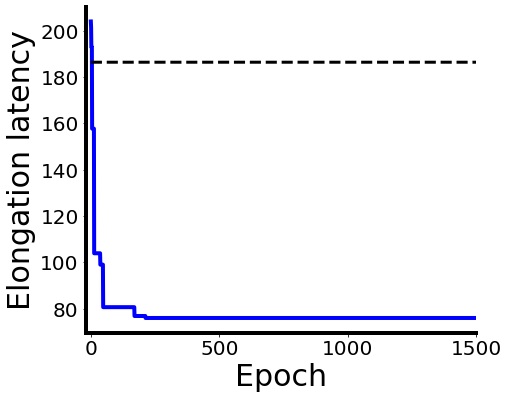

In [209]:
import matplotlib.pyplot as plt
import numpy as np
minelong = np.load('minelong_arr2-RandomtRNARandomCodon_1500sample.npy')


fig,ax = plt.subplots(figsize=(7,6))
ax.plot(np.arange(1500),minelong,linewidth=4,color='blue')
ax.plot(np.arange(1500),[186.4]*1500,linewidth=3,color='black',linestyle='dashed')
ax.set_xlim(-20,1500)


ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)
ax.set_ylabel('Elongation latency',fontsize=30)
ax.set_xlabel('Epoch',fontsize=30)

Text(0.5, 0, 'Epoch')

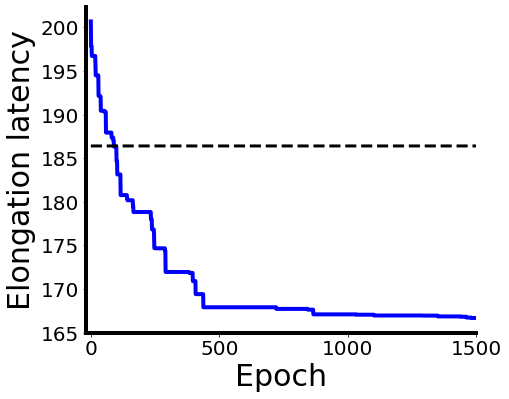

In [2]:
import matplotlib.pyplot as plt
import numpy as np
minelong = np.load('minelong_arr2-tRNA.npy')
fig,ax = plt.subplots(figsize=(7,6))
ax.plot(np.arange(1500),minelong,linewidth=4,color='blue')
ax.plot(np.arange(1500),[186.4]*1500,linewidth=3,color='black',linestyle='dashed')
ax.set_xlim(-20,1500)


ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)
ax.set_ylabel('Elongation latency',fontsize=30)
ax.set_xlabel('Epoch',fontsize=30)

Text(0.5, 0, 'Epoch')

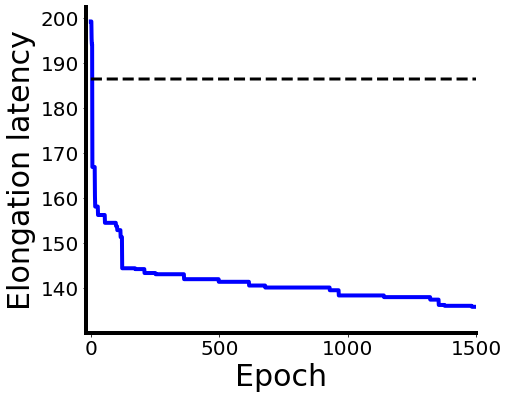

In [69]:
import matplotlib.pyplot as plt
import numpy as np
minelong = np.load('minelong_arr2-RandomCodon.npy')

fig,ax = plt.subplots(figsize=(7,6))
ax.plot(np.arange(2000),minelong,linewidth=4,color='blue')
ax.plot(np.arange(2000),[186.4]*2000,linewidth=3,color='black',linestyle='dashed')
ax.set_xlim(-20,1500)


ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)
ax.set_ylabel('Elongation latency',fontsize=30)
ax.set_xlabel('Epoch',fontsize=30)

Text(0.5, 0, 'Epoch')

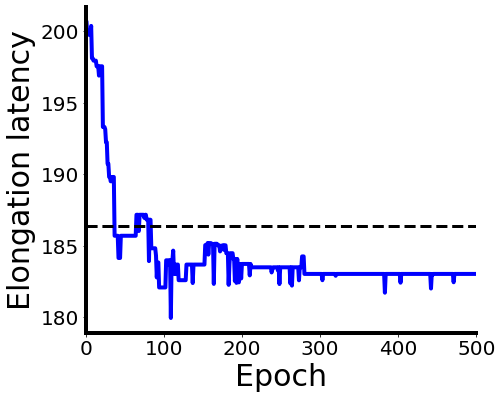

In [64]:
import matplotlib.pyplot as plt
import numpy as np
minelong = np.load('minelong_arr2.npy')

fig,ax = plt.subplots(figsize=(7,6))
ax.plot(np.arange(500),minelong,linewidth=4,color='blue')
ax.plot(np.arange(500),[186.4]*500,linewidth=3,color='black',linestyle='dashed')
ax.set_xlim(0,500)


ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)
ax.set_ylabel('Elongation latency',fontsize=30)
ax.set_xlabel('Epoch',fontsize=30)

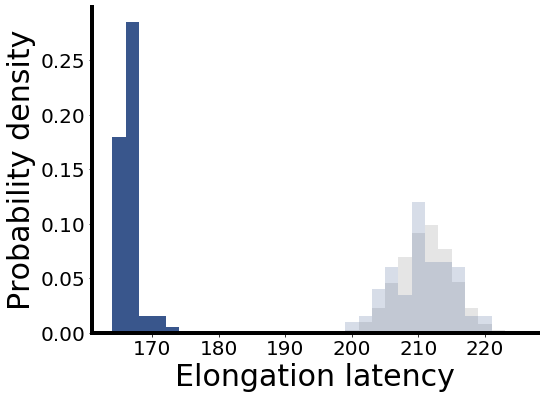

In [200]:
fig,ax = plt.subplots(figsize=(8,6))
#ax.fill_between(np.linspace(160,186.4,2), [0]*2,max(hist[0])*2,alpha=0.1,color='green')


#hist=ax.hist(elong_t_tRNA_list,20,color='grey',density=True)
#ax.plot([186.4]*100,np.linspace(0,max(hist[0]),100),linewidth=3,color='green')
#ax.plot([212]*100,np.linspace(0,max(hist[0]),100),linewidth=3,color='blue')


p_tRNA_list=np.load('RandomtRNA_FixedCodon_1500sample_p_tRNA_list.npy')
elong_t_tRNA_list=np.load('RandomtRNA_FixedCodon_1500sample_elong_t_list.npy')


hist=ax.hist(elong_t_tRNA_list,15,range=(164,194),color='#39568CFF',density=True)
#ax.plot([186.4]*100,np.linspace(0,max(hist[0]),100),linewidth=3,color='green')

p_tRNA_list=np.load('RandomtRNA_FixedCodon_10ksample_p_Codon_tRNA_list.npy')
elong_t_tRNA_list=np.load('RandomtRNA_FixedCodon_10ksample_elong_t_list.npy')
hist=ax.hist(elong_t_tRNA_list,15,range = (195,225),color='grey',density=True,alpha=0.2)
#ax.plot([212]*100,np.linspace(0,max(hist[0]),100),linewidth=3,color='blue')

elong_t_tRNA_list = np.load('RandomtRNA_FixedCodon_100sample_elong_t_list.npy')
hist=ax.hist(elong_t_tRNA_list,15,range = (195,225),color='#39568CFF',density=True,alpha=0.2)
for ax in [ax]:
    ax.spines['left'].set_linewidth(4)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(axis='y', which='major', labelsize=20)
    ax.tick_params(axis='x', which='major', labelsize=20)
    ax.set_ylabel('Probability density',fontsize=30)
    ax.set_xlabel('Elongation latency',fontsize=30)

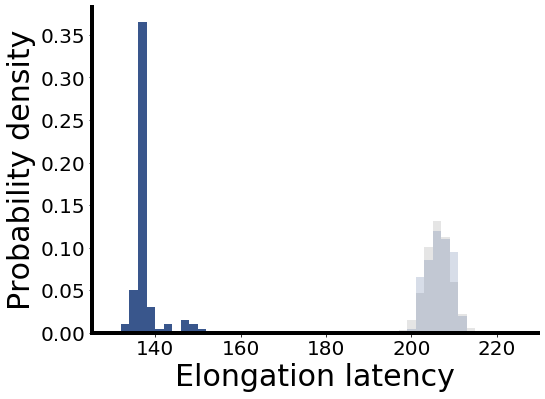

In [205]:
fig,ax = plt.subplots(figsize=(8,6))
#ax.fill_between(np.linspace(160,186.4,2), [0]*2,max(hist[0])*2,alpha=0.1,color='green')


#hist=ax.hist(elong_t_tRNA_list,20,color='grey',density=True)
#ax.plot([186.4]*100,np.linspace(0,max(hist[0]),100),linewidth=3,color='green')
#ax.plot([212]*100,np.linspace(0,max(hist[0]),100),linewidth=3,color='blue')


p_tRNA_list=np.load('FixedtRNA_RandomCodon_2000sample_p_tRNA_list.npy')
elong_t_tRNA_list=np.load('FixedtRNA_RandomCodon_2000sample_elong_t_list.npy')

hist=ax.hist(elong_t_tRNA_list,15,range=(130,160),color='#39568CFF',density=True)
#ax.plot([186.4]*100,np.linspace(0,max(hist[0]),100),linewidth=3,color='green')

p_tRNA_list=np.load('FixedtRNA_RandomCodon_10ksample_p_Codon_tRNA_list.npy')
elong_t_tRNA_list=np.load('FixedtRNA_RandomCodon_10ksample_elong_t_list.npy')
hist=ax.hist(elong_t_tRNA_list,15,range = (195,225),color='grey',density=True,alpha=0.2)
#ax.plot([212]*100,np.linspace(0,max(hist[0]),100),linewidth=3,color='blue')

elong_t_tRNA_list = np.load('FixedtRNA_RandomCodon_100sample_elong_t_list.npy')
hist=ax.hist(elong_t_tRNA_list,15,range = (195,225),color='#39568CFF',density=True,alpha=0.2)
for ax in [ax]:
    ax.spines['left'].set_linewidth(4)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(axis='y', which='major', labelsize=20)
    ax.tick_params(axis='x', which='major', labelsize=20)
    ax.set_ylabel('Probability density',fontsize=30)
    ax.set_xlabel('Elongation latency',fontsize=30)

[205.03379411 197.87076044 156.54153014 211.78560906 199.16385742
 203.73552679 204.18688316 204.91435434 187.41357239 203.27116085
 204.43721332 202.39104763 201.84338566 205.00534379 198.89467353
 229.33699295 184.7855314  206.58189977 203.79487294 202.04726983
 201.21245687 204.76255958 203.75131766 198.31694031 205.17164405
 201.67032604 205.01398839 204.95907935 198.37923316 203.74659203
 204.89752087 202.5670879  204.66551652 203.96580619 201.51986149
 181.78807704 202.13396462 203.60444693 201.20455806 203.48466159
 201.26316275 201.51424968 204.2796187  203.53026168 198.47598174
 205.22943376 227.25910852 195.84901144 197.85763521 205.1919128
 204.66432005 203.32256951 204.79491118 180.04652158 201.04914201
 204.47131613 204.68639073 203.80955635 202.93050649 201.27000208
 200.64906786 203.52628309 204.90427588 197.65457814 204.71288645
 204.68011819 202.31629358 205.1768468  203.5437874  206.18949783
 202.65258789 199.5547477  201.91391766 204.93802072 203.24965451
 202.556640

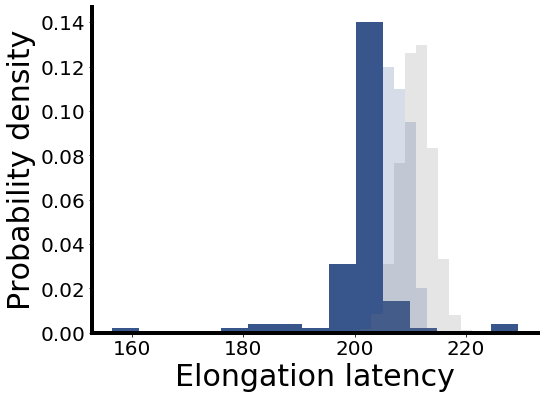

In [215]:
#varying tRNA, varying codon

fig,ax = plt.subplots(figsize=(8,6))

elong_t_tRNA_list=np.load('RandomtRNA_RandomCodon_1500sample_elong_t_list.npy')
print(elong_t_tRNA_list)

hist=ax.hist(elong_t_tRNA_list,15,color='#39568CFF',density=True)
#ax.plot([186.4]*100,np.linspace(0,max(hist[0]),100),linewidth=3,color='green')

p_tRNA_list=np.load('RandomtRNA_RandomCodon_10ksample_p_Codon_tRNA_list.npy')
elong_t_tRNA_list=np.load('RandomtRNA_RandomCodon_10ksample_elong_t_list.npy')
hist=ax.hist(elong_t_tRNA_list,15,range = (195,225),color='grey',density=True,alpha=0.2)
#ax.plot([212]*100,np.linspace(0,max(hist[0]),100),linewidth=3,color='blue')

elong_t_tRNA_list = np.load('FixedtRNA_RandomCodon_100sample_elong_t_list.npy')
hist=ax.hist(elong_t_tRNA_list,15,range = (195,225),color='#39568CFF',density=True,alpha=0.2)
for ax in [ax]:
    ax.spines['left'].set_linewidth(4)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(axis='y', which='major', labelsize=20)
    ax.tick_params(axis='x', which='major', labelsize=20)
    ax.set_ylabel('Probability density',fontsize=30)
    ax.set_xlabel('Elongation latency',fontsize=30)

Text(0.5, 0, 'Epoch')

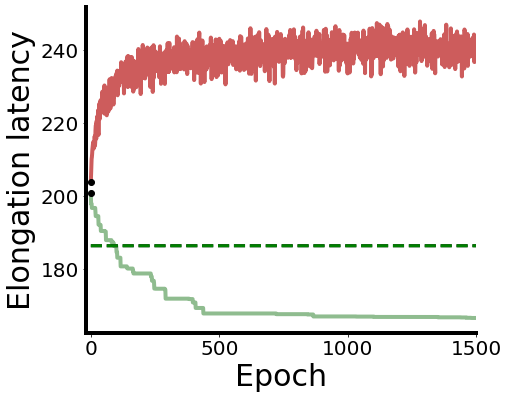

In [65]:
import matplotlib.pyplot as plt
import numpy as np
minelong = np.load('minelong_arr2-tRNA.npy')
fig,ax = plt.subplots(figsize=(7,6))
ax.plot(np.arange(1500),minelong,linewidth=4,color='darkseagreen')
ax.plot(np.arange(1500),[186.4]*1500,linewidth=3,color='black',linestyle='dashed')
ax.set_xlim(-20,1500)

maxelong_slow = np.load('Slower_minelong_arr2-tRNA.npy')
ax.plot(np.arange(1500),maxelong_slow,linewidth=4,color='indianred')
ax.plot(np.arange(1500),[186.4]*1500,linewidth=3,color='green',linestyle='dashed')

ax.scatter([0],maxelong_slow[0],color='black',zorder=10)
ax.scatter([0],minelong[0],color='black',zorder=10)


ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)
ax.set_ylabel('Elongation latency',fontsize=30)
ax.set_xlabel('Epoch',fontsize=30)

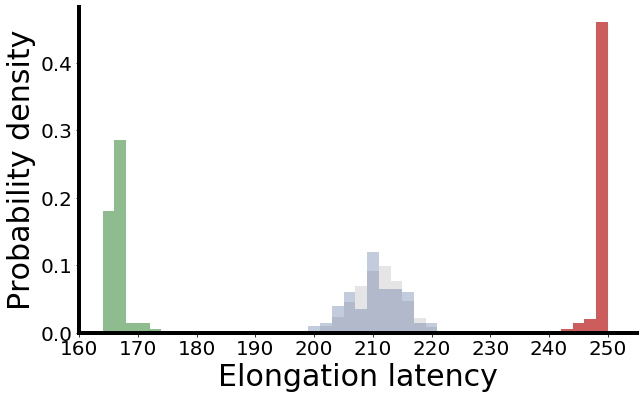

In [32]:
###Varying tRNA
fig,ax = plt.subplots(figsize=(10,6))

p_tRNA_list=np.load('RandomtRNA_FixedCodon_1500sample_p_tRNA_list.npy')
elong_t_tRNA_list=np.load('RandomtRNA_FixedCodon_1500sample_elong_t_list.npy')
hist=ax.hist(elong_t_tRNA_list,15,range=(164,194),color='darkseagreen',density=True)

elong_t_tRNA_list=np.load('Slower_RandomtRNA_FixedCodon_1500sample_elong_t_list2.npy')
hist=ax.hist(elong_t_tRNA_list,15,range=(240,270),color='indianred',density=True)

p_tRNA_list=np.load('RandomtRNA_FixedCodon_10ksample_p_Codon_tRNA_list.npy')
elong_t_tRNA_list=np.load('RandomtRNA_FixedCodon_10ksample_elong_t_list.npy')
hist=ax.hist(elong_t_tRNA_list,15,range = (195,225),color='grey',density=True,alpha=0.2)

elong_t_tRNA_list = np.load('RandomtRNA_FixedCodon_100sample_elong_t_list.npy')
hist=ax.hist(elong_t_tRNA_list,15,range = (195,225),color='#39568CFF',density=True,alpha=0.3)
for ax in [ax]:
    ax.spines['left'].set_linewidth(4)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(axis='y', which='major', labelsize=20)
    ax.tick_params(axis='x', which='major', labelsize=20)
    ax.set_ylabel('Probability density',fontsize=30)
    ax.set_xlabel('Elongation latency',fontsize=30)
    ax.set_xlim(160,255)
    ax.set_xticks(np.arange(160,260,10))

Text(0.5, 0, 'Epoch')

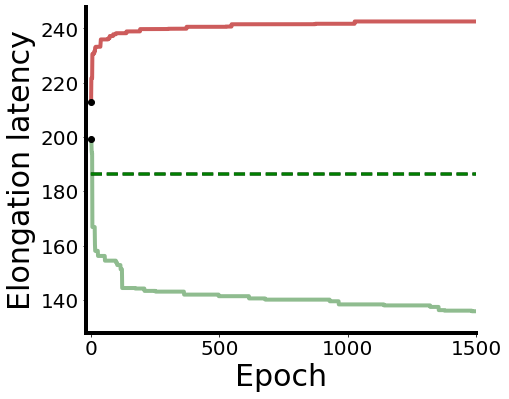

In [64]:
import matplotlib.pyplot as plt
import numpy as np
minelong = np.load('minelong_arr2-RandomCodon.npy')
fig,ax = plt.subplots(figsize=(7,6))
ax.plot(np.arange(2000),minelong,linewidth=4,color='darkseagreen')
ax.plot(np.arange(2000),[186.4]*2000,linewidth=3,color='black',linestyle='dashed')
ax.set_xlim(-20,1500)

maxelong_slow = np.load('maxelong_arr2-RandomCodon_slow.npy')
ax.plot(np.arange(1500),maxelong_slow,linewidth=4,color='indianred',zorder=5)
ax.plot(np.arange(1500),[186.4]*1500,linewidth=3,color='green',linestyle='dashed')

ax.scatter([0],maxelong_slow[0],color='black',zorder=10)
ax.scatter([0],minelong[0],color='black',zorder=10)


ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)
ax.set_ylabel('Elongation latency',fontsize=30)
ax.set_xlabel('Epoch',fontsize=30)

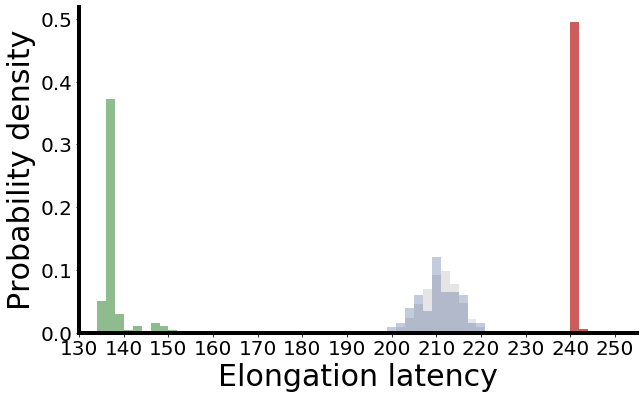

In [31]:
###Varying Codons
fig,ax = plt.subplots(figsize=(10,6))

p_tRNA_list=np.load('FixedtRNA_RandomCodon_2000sample_p_tRNA_list.npy')
elong_t_tRNA_list=np.load('FixedtRNA_RandomCodon_2000sample_elong_t_list.npy')
hist=ax.hist(elong_t_tRNA_list,15,range=(134,164),color='darkseagreen',density=True)

elong_t_tRNA_list=np.load('FixedtRNA_RandomCodon_1500sample_elong_t_list_slow.npy')
hist=ax.hist(elong_t_tRNA_list,15,range=(240,270),color='indianred',density=True)

p_tRNA_list=np.load('RandomtRNA_FixedCodon_10ksample_p_Codon_tRNA_list.npy')
elong_t_tRNA_list=np.load('RandomtRNA_FixedCodon_10ksample_elong_t_list.npy')
hist=ax.hist(elong_t_tRNA_list,15,range = (195,225),color='grey',density=True,alpha=0.2)

elong_t_tRNA_list = np.load('RandomtRNA_FixedCodon_100sample_elong_t_list.npy')
hist=ax.hist(elong_t_tRNA_list,15,range = (195,225),color='#39568CFF',density=True,alpha=0.3)
for ax in [ax]:
    ax.spines['left'].set_linewidth(4)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(axis='y', which='major', labelsize=20)
    ax.tick_params(axis='x', which='major', labelsize=20)
    ax.set_ylabel('Probability density',fontsize=30)
    ax.set_xlabel('Elongation latency',fontsize=30)
    ax.set_xlim(160,255)
    ax.set_xticks(np.arange(130,260,10))

In [ ]:
#tRNA-codon cognate, non-cognate map



[ 6.16066344e-03 -1.26152373e-03  1.07007802e-02 -3.42523540e-02
  7.34847800e-02  3.08215215e-01 -1.57040104e-02 -3.39970170e-02
 -1.30337290e-02 -1.83659769e-02 -4.15393695e-02 -7.66909629e-03
  9.34657779e-04 -2.46526743e-02 -3.22177739e-02 -1.18356339e-02
  2.03812235e-06 -4.40865813e-04 -2.19000488e-03 -9.33988031e-03
 -1.01710947e-02 -3.83835154e-02 -5.58371636e-03 -2.93861704e-02
 -1.59827605e-02  4.34726320e-02  1.76629691e-02 -4.38405329e-02
  3.98178919e-04 -2.61792903e-03 -2.07463273e-02 -2.68516978e-02
 -6.99403071e-03 -1.51084944e-04 -2.69912949e-03  5.97594470e-04
  2.94631996e-03 -1.62466145e-02 -3.65225707e-03 -2.75079050e-03
 -7.85717309e-03 -2.31975534e-02 -4.24449847e-04 -1.82945015e-03
 -1.59089418e-02 -1.15287119e-02 -4.67110953e-04  5.28798441e-02
 -4.37561498e-02  2.16994866e-01 -2.63055467e-02 -6.77790805e-03
 -6.18434899e-03 -1.36319309e-02 -6.12010360e-02 -7.39609299e-04
 -3.88911096e-03 -2.91978780e-04 -2.89708880e-02 -3.73371263e-03
 -4.41106117e-03 -7.86305

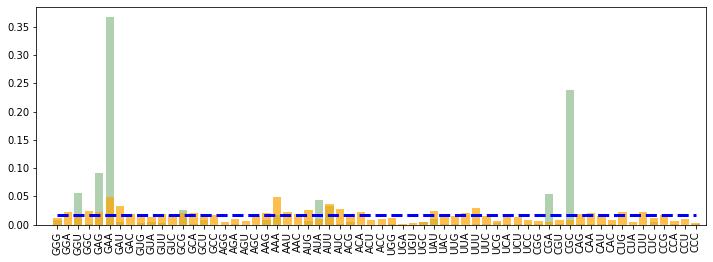

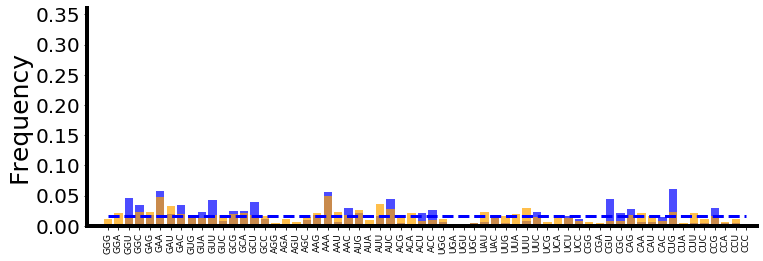

In [49]:
#Bsub
import pandas as pd
pCodon = pd.read_excel('bsub_codonValues.xlsx',header=None)
bsub_pCodon = pCodon[1]/sum(pCodon[1])

gr25_ptRNA = [0.0602409638554217, 0.010542168674698798, 0.07379518072289158, 0.00602409638554217, 0.010542168674698798, 0.00602409638554217, 0.021084337349397596, 0.043674698795180725, 0.021084337349397596, 0.01204819277108434, 0.01807228915662651, 0.08433734939759038, 0.03162650602409639, 0.07228915662650603, 0.01204819277108434, 0.07078313253012049, 0.06325301204819278, 0.01656626506024097, 0.009036144578313254, 0.027108433734939763, 0.010542168674698798, 0.03012048192771085, 0.013554216867469882, 0.015060240963855425, 0.0075301204819277125, 0.010542168674698798, 0.0075301204819277125, 0.003012048192771085, 0.021084337349397596, 0.004518072289156627, 0.01656626506024097, 0.01204819277108434, 0.0015060240963855425, 0.009036144578313254, 0.01656626506024097, 0.019578313253012052, 0.015060240963855425, 0.027108434, 0.05873493975903616, 0.019578313]
gr25_ptRNA = gr25_ptRNA/np.sum(gr25_ptRNA)
p_tRNA_list=np.load('RandomtRNA_FixedCodon_1500sample_p_tRNA_list.npy')
elong_t_tRNA_list=np.load('RandomtRNA_FixedCodon_1500sample_elong_t_list.npy')

tRNA_tags = ["Ala1B", "Ala2", "Arg2", "Arg3", "Arg4", "Arg5", "Asn", "Asp1", "Cys", "Gln1", "Gln2", \
"Glu2", "Gly2", "Gly3", "His", "Ile1", "Leu1", "Leu2", "Leu3", "Leu4", "Leu5", "Lys", \
"Met", "Phe", "Pro1", "Pro2", "Pro3", "Sec", "Ser1", "Ser2", "Ser3", "Ser5", "Thr1", \
"Thr2", "Thr3", "Thr4", "Trp", "Tyr1/2", "Val1", "Val2A/2B"]

gr25_Codon = np.array([2.36, 1.26, 45.55, 34.17, 16.97, 57.86, 19.27, 33.74, 14.98, 22.31, 43.18, 7.67, 24.11, 24.87, 39.49, 11.81, 0.03, 0.63, 2.19, 9.31, 17.22, 55.01, 5.61, 29.21, 21.67, 0.52, 15.79, 43.86, 4.17, 2.61, 20.64, 26.7, 7.03, 0.19, 2.76, 3.81, 6.72, 16.52, 4.27, 2.73, 7.92, 23.25, 2.51, 1.98, 16.33, 11.68, 0.62, 0.67, 43.82, 20.59, 27.28, 7.01, 6.78, 14.21, 60.75, 0.82, 3.86, 4.09, 28.82, 5.18, 4.38, 1.09])
gr25_pCodon = gr25_Codon/np.sum(gr25_Codon)
codon_tags = ['GGG', 'GGA', 'GGU', 'GGC', 'GAG', 'GAA', 'GAU', 'GAC', 'GUG', 'GUA', 'GUU', 'GUC', 'GCG', 'GCA', 'GCU', 'GCC', 'AGG', 'AGA', 'AGU', 'AGC', 'AAG', 'AAA', 'AAU', 'AAC', 'AUG', 'AUA', 'AUU', 'AUC', 'ACG', 'ACA', 'ACU', 'ACC', 'UGG', 'UGA', 'UGU', 'UGC', 'UAU', 'UAC', 'UUG', 'UUA', 'UUU', 'UUC', 'UCG', 'UCA', 'UCU', 'UCC', 'CGG', 'CGA', 'CGU', 'CGC', 'CAG', 'CAA', 'CAU', 'CAC', 'CUG', 'CUA', 'CUU', 'CUC', 'CCG', 'CCA', 'CCU', 'CCC']


p_Codon_list = np.load('FixedtRNA_RandomCodon_2000sample_p_tRNA_list.npy')
elong_t_Codon_list = np.load('FixedtRNA_RandomCodon_2000sample_elong_t_list.npy')

fig,ax = plt.subplots(figsize=(12,4))
#ax.bar(np.arange(62),gr25_pCodon,color='#39568CFF',width=0.8,alpha=0.5)
ax.bar(np.arange(62),p_Codon_list[np.argmin(elong_t_Codon_list)],color='darkseagreen',width=0.8,alpha=0.7)

ax.bar(np.arange(62),bsub_pCodon,color='orange',width=0.8,alpha=0.7)

ax.plot(np.arange(62),[1/62]*62,color='blue',linewidth=3,linestyle='dashed')
plt.xticks(range(len(codon_tags)), codon_tags,rotation='vertical')
ax.set_xlim(-2,62)
codon_dist = (p_Codon_list[np.argmin(elong_t_Codon_list)] - gr25_pCodon)
print(codon_dist)
print(sum(codon_dist))

fig,ax = plt.subplots(figsize=(12,4))
ax.bar(np.arange(62),gr25_pCodon,color='blue',width=0.8,alpha=0.7)
ax.bar(np.arange(62),bsub_pCodon,color='orange',width=0.8,alpha=0.7)
ax.plot(np.arange(62),[1/62]*62,color='blue',linewidth=3,linestyle='dashed')
plt.xticks(range(len(codon_tags)), codon_tags,rotation='vertical')
ax.set_xlim(-2,62)


codon_dist = (p_Codon_list[np.argmin(elong_t_tRNA_list)] - gr25_pCodon)
codon_dist_norm = sum(np.abs(codon_dist)) ## Show plot of this too with epoch? With both fitness functions.
print('normed tRNA dist fast and WT coli', codon_dist_norm)

codon_dist = (bsub_pCodon - p_Codon_list[np.argmin(elong_t_tRNA_list)])
codon_dist_norm = sum(np.abs(codon_dist)) ## Show plot of this too with epoch? With both fitness functions.
print('normed tRNA dist bsub and fast coli', codon_dist_norm)

codon_dist = (bsub_pCodon - gr25_pCodon )
codon_dist_norm = sum(np.abs(codon_dist)) ## Show plot of this too with epoch? With both fitness functions.
print('normed tRNA dist bsub and WT coli', codon_dist_norm)


##Percent apart

codon_dist = (p_Codon_list[np.argmin(elong_t_tRNA_list)]/gr25_pCodon)
codon_dist_norm = sum(np.abs(codon_dist)) ## Show plot of this too with epoch? With both fitness functions.
print('normed tRNA dist fast and WT coli', codon_dist_norm)

codon_dist = (bsub_pCodon/p_Codon_list[np.argmin(elong_t_tRNA_list)])
codon_dist_norm = sum(np.abs(codon_dist)) ## Show plot of this too with epoch? With both fitness functions.
print('normed tRNA dist bsub and fast coli', codon_dist_norm)

codon_dist = (bsub_pCodon/gr25_pCodon )
codon_dist_norm = sum(np.abs(codon_dist)) ## Show plot of this too with epoch? With both fitness functions.
print('normed tRNA dist bsub and WT coli', codon_dist_norm)


codon_dist_fastWT = (p_Codon_list[np.argmin(elong_t_tRNA_list)] - gr25_pCodon)
codon_dist_bsubWT = (bsub_pCodon - gr25_pCodon)

positive_count = 0;
positive_count_bsub = 0;
for i,_ in enumerate(codon_dist_fastWT):
    if(codon_dist_fastWT[i]>0):
        positive_count += 1;
    if(codon_dist_bsubWT[i]>0):
        positive_count_bsub += 1;    
print(positive_count,positive_count_bsub)

for ax in [ax]:
    ax.spines['left'].set_linewidth(4)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(axis='y', which='major', labelsize=20)
    ax.tick_params(axis='x', which='major', labelsize=9)
    ax.set_ylabel('Frequency',fontsize=25)
    ax.set_ylim(0,0.36)
    ax.set_yticks(np.arange(0,0.36,0.05))

In [51]:
print(list(bsub_pCodon))
print(gr25_pCodon)

[0.011225819384584543, 0.02185025558785206, 0.013029968928535631, 0.02335371354114463, 0.0226520998296081, 0.04821088503558184, 0.033276536032875614, 0.019043800741705922, 0.017339881727974342, 0.013029968928535631, 0.018642878620827905, 0.017339881727974342, 0.019845644983461964, 0.021148641876315526, 0.018642878620827905, 0.0165380374862183, 0.004109451738999699, 0.01052420567304801, 0.00681567605492633, 0.0144331963516087, 0.020847950285657012, 0.04851157662624035, 0.02295279142026661, 0.017841034379071866, 0.026360629447729777, 0.009822591961511477, 0.03628345193946076, 0.02726270421970532, 0.014934349002706224, 0.02164979452741305, 0.008720056129096921, 0.009020747719755437, 0.010724666733487018, 0.0008018442417560389, 0.003608299087902175, 0.004309912799438709, 0.02335371354114463, 0.012629046807657612, 0.01583642377468177, 0.019845644983461964, 0.030069159065851458, 0.014332965821389196, 0.006514984464267816, 0.014633657412047708, 0.012729277337877116, 0.008319134008218904, 0.00

In [52]:
print(list(bsub_pCodon)-gr25_pCodon)

[ 0.00884784  0.02058066 -0.03286701 -0.01107658  0.00555283 -0.01008987
  0.01385975 -0.01495322  0.00224577 -0.00944998 -0.02486605  0.00961145
 -0.00444802 -0.00391081 -0.02114794  0.00463807  0.00407922  0.00988941
  0.00460899  0.00505228  0.00349678 -0.00691747  0.01730006 -0.01159148
  0.00452556  0.00929863  0.02037317 -0.0169314   0.01073258  0.01901991
 -0.01207717 -0.01788264  0.00364112  0.0006104   0.00082727  0.00047089
  0.01658252 -0.0040168   0.0115339   0.01709485  0.02208883 -0.00909414
  0.00398586  0.01263857 -0.00372512 -0.00344984  0.00629118  0.00363481
 -0.0369372  -0.01252794 -0.00894516  0.01338363  0.00890455 -0.00680096
 -0.03815975  0.00408505  0.01796085  0.00660351 -0.01270196  0.00189691
  0.00621107  0.00240977]


In [54]:
print(p_Codon_list[np.argmin(elong_t_tRNA_list)]-gr25_pCodon)

[ 1.18813125e-02 -1.26681175e-03 -2.31142741e-02 -1.50703826e-02
  6.63164965e-02  2.79211319e-01 -1.59978178e-02 -3.35314452e-02
 -1.31337594e-02 -1.86915322e-02 -4.16349904e-02 -7.67818138e-03
 -2.90162700e-04  3.09047299e-02  1.14210881e-03 -1.17796776e-02
 -3.40189183e-06 -4.56212539e-04 -2.19255867e-03 -9.34312792e-03
 -1.30138449e-02 -5.52660224e-02 -5.62664710e-03 -2.93898374e-02
 -1.64458778e-02  4.74870596e-02 -1.05978272e-02 -4.38685127e-02
 -1.62134956e-03 -2.61975933e-03 -1.03437996e-02 -2.68539088e-02
 -7.00588229e-03  8.51107318e-03 -2.59058851e-03 -3.76391292e-03
  2.17733395e-03 -1.62782070e-02 -3.70371558e-03 -2.75079094e-03
 -7.83761042e-03 -2.32157190e-02 -6.95122656e-04 -1.84255734e-03
 -1.59521058e-02 -1.12350295e-02 -4.85163395e-04  4.42923449e-02
 -4.37876177e-02  2.20791626e-01 -2.74238343e-02 -6.80050013e-03
 -6.17485563e-03 -1.40969183e-02 -6.12078386e-02 -7.50751335e-04
 -3.88914863e-03 -3.24729816e-03 -2.89727675e-02 -3.95350732e-03
 -4.41124349e-03 -8.10994

In [97]:
ptRNA = pd.read_excel('bsub_tRNAValues.xlsx',header=None)
bsub_ptRNA = ptRNA[1]/np.nansum(ptRNA[1])
bsub_ptRNA = np.nan_to_num(bsub_ptRNA)

pCodon = pd.read_excel('bsub_codonValues.xlsx',header=None)
bsub_pCodon = pCodon[1]/sum(pCodon[1])


R^2 0.2901690391631605
1.6323263283986305


(-0.005, 0.065)

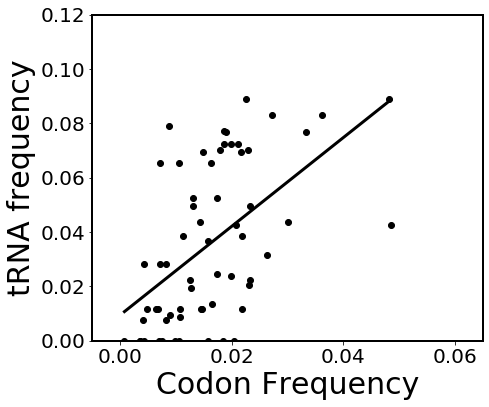

In [107]:
#### trna frequency vs codon frequency, ga faster, tRNA random, codon random
from analysis_utils import *
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
%matplotlib inline
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#np.save('',elong_t_Codon_list)
#np.save('',p_Codon_list)

gr25_Codon = np.array([2.36, 1.26, 45.55, 34.17, 16.97, 57.86, 19.27, 33.74, 14.98, 22.31, 43.18, 7.67, 24.11, 24.87, 39.49, 11.81, 0.03, 0.63, 2.19, 9.31, 17.22, 55.01, 5.61, 29.21, 21.67, 0.52, 15.79, 43.86, 4.17, 2.61, 20.64, 26.7, 7.03, 0.19, 2.76, 3.81, 6.72, 16.52, 4.27, 2.73, 7.92, 23.25, 2.51, 1.98, 16.33, 11.68, 0.62, 0.67, 43.82, 20.59, 27.28, 7.01, 6.78, 14.21, 60.75, 0.82, 3.86, 4.09, 28.82, 5.18, 4.38, 1.09])
gr25_pCodon = gr25_Codon/np.sum(gr25_Codon)
gr25_ptRNA = [0.0602409638554217, 0.010542168674698798, 0.07379518072289158, 0.00602409638554217, 0.010542168674698798, 0.00602409638554217, 0.021084337349397596, 0.043674698795180725, 0.021084337349397596, 0.01204819277108434, 0.01807228915662651, 0.08433734939759038, 0.03162650602409639, 0.07228915662650603, 0.01204819277108434, 0.07078313253012049, 0.06325301204819278, 0.01656626506024097, 0.009036144578313254, 0.027108433734939763, 0.010542168674698798, 0.03012048192771085, 0.013554216867469882, 0.015060240963855425, 0.0075301204819277125, 0.010542168674698798, 0.0075301204819277125, 0.003012048192771085, 0.021084337349397596, 0.004518072289156627, 0.01656626506024097, 0.01204819277108434, 0.0015060240963855425, 0.009036144578313254, 0.01656626506024097, 0.019578313253012052, 0.015060240963855425, 0.027108434, 0.05873493975903616, 0.019578313]
gr25_ptRNA = gr25_ptRNA/np.sum(gr25_ptRNA)

ptRNA_dict, pcodon_dict, codon_dict, codon_labels, pCodon = cognateDistrib(bsub_ptRNA,bsub_pCodon,True)


codonp_sorted = sorted(pcodon_dict.items(),key=lambda kv: kv[1])[::-1]
codonp_sorted_codon = [x[0] for x in codonp_sorted]
codonp_sorted_p = [x[1] for x in codonp_sorted]

codon_tRNA_sorted = [codon_dict[codon] for codon in codonp_sorted_codon]

codonp_sorted = sorted(pcodon_dict.items(),key=lambda kv: kv[1])[::-1]
codonp_sorted_codon = [x[0] for x in codonp_sorted]
codonp_sorted_p = [x[1] for x in codonp_sorted]
#print(codonp_sorted)

codon_tRNA_sorted = [codon_dict[codon] for codon in codonp_sorted_codon]
codon_tRNA_sorted_p = [sum(ptRNA_dict[tRNA] for tRNA in codon_dict[codon]) for codon in codonp_sorted_codon]
#ax2 = ax.twinx()
fig,ax = plt.subplots(figsize=(7,6))
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)

ax.scatter(codonp_sorted_p,codon_tRNA_sorted_p,color='black',label = 'Protein-coding codon')
ax.set_xlabel('Codon Frequency',fontsize=30)
ax.set_ylabel('tRNA frequency',fontsize=30)
#ax.set_xlim(-0.005,0.065)


def calc_R2(x,y,y_hat):
    SS_err = np.sum((y-y_hat)**2) # Sum of squared errors
    SS_tot = np.sum((y-np.average(y))**2) #Sum of squares total (proportional to variance; n times larger than variance)
    return 1-SS_err/SS_tot

y_model,SS_err,_,_,_ = np.polyfit(codonp_sorted_p,codon_tRNA_sorted_p,1,full=True)
y_hat = np.polyval(y_model,codonp_sorted_p)
x_sweep_i = np.linspace(min(codonp_sorted_p),max(codonp_sorted_p),1000)
y_hat_sweep_i = np.polyval(y_model, x_sweep_i)
ax.plot(x_sweep_i,y_hat_sweep_i,linewidth=3,color='black')
print("R^2",calc_R2(codonp_sorted_p,codon_tRNA_sorted_p,y_hat))

slope, intercept = np.polyfit(codonp_sorted_p,codon_tRNA_sorted_p,1)
print(slope)

ax.set_ylim(0,0.12)

ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.set_xlim(-0.005,0.065)

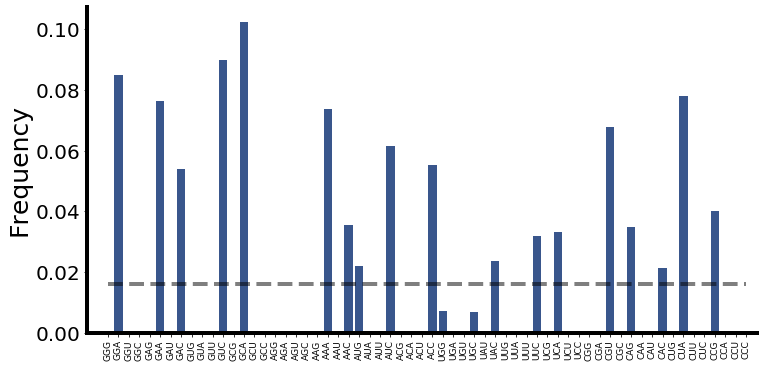

R^2 0.0001262561545605223
0.006359149666043943


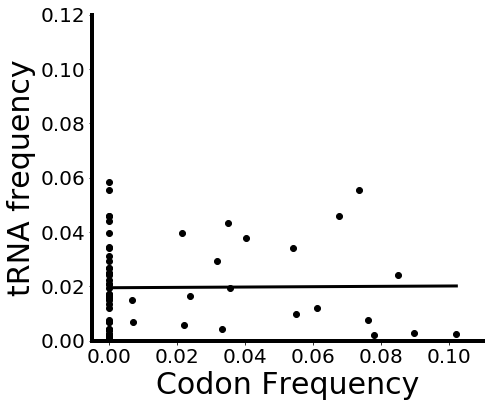